In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from pathlib import Path
from PIL import Image
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

## Load data

In [3]:
IMAGE_DIR = "../data"

In [4]:
image_path = Path(IMAGE_DIR)

In [5]:
path_classes = [ d for d in image_path.iterdir() if d.is_dir() and not d.name.startswith('.')]

In [6]:
samples = []
for path in path_classes:
    files = list(path.glob('*.png'))
    for file in files:
        samples.append((file , 1.0 if path.name == "cat" else 0.0))

In [7]:
transform = transforms.ToTensor()

In [8]:
random.shuffle(samples)

In [9]:
X = torch.zeros(len(samples),3,128,128)
y = torch.zeros(len(samples))

In [10]:
for idx in range(len(samples)):
    X[idx] = transform(Image.open(samples[idx][0]).resize((128,128)))
    y[idx] = samples[idx][1]

Above code loads images from IMAGE_DIR, shuffles the samples and then creates corresponding tensors. X for data and y for lables. In the lables 1.0 means cat and 0.0 means dog

In [11]:
len(y)

1544

## Build the model

In [12]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=3*128*128,out_features=16*16),
            nn.ReLU(),
            nn.Linear(in_features=16*16,out_features=16*16),
            nn.ReLU(),
            nn.Linear(in_features=16*16,out_features=1)
        )
    def forward(self, x, **kwargs):
        x = x.view(x.size(0), -1)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
class MyResNet50(nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        return torch.sigmoid(x)

In [15]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))

        x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))

        x = x.view(-1, 64 * 32 * 32)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [16]:
class EnhancedCNNMoreDropout(nn.Module):
    def __init__(self):
        super(EnhancedCNNMoreDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = self.dropout2(x)

        x = x.view(-1, 64 * 32 * 32)

        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [17]:
class DeepSketch(nn.Module):
    def __init__(self):
        super(DeepSketch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=5, stride=1, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(4096,1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool4(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(-1, 4096)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    

In [18]:
model = DeepSketch()
model.to(device)

DeepSketch(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(512, 4096, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

### Setup training loop

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [21]:
percentage = 0.8
split_index = int(len(X)*percentage)
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [22]:
EPOCHS = 200
MODEL_PATH = 'classifier_deep_sketch_weights_200.pth'

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    total_test_loss = 0
    total_test_acc = 0
    
    for X_batch, y_batch in train_loader:
        y_logits = model(X_batch).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_fn(y_batch, y_pred)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_acc = total_acc / len(train_loader)
    train_accs.append(avg_acc)
    model.eval()

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            test_logits = model(X_batch).squeeze()
            test_y_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_batch)

            total_test_loss += test_loss.item()
            total_test_acc += accuracy_fn(y_batch, test_y_pred)
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    avg_test_acc = total_test_acc / len(test_loader)
    test_accs.append(avg_test_acc)
    if (epoch % 50 == 0) or (epoch == EPOCHS-1):
        print(f"Epoch {epoch} | Average Loss: {avg_loss:.5f} - Average Acc: {avg_acc:.2f}% | Average Test Loss: {avg_test_loss:.5f} - Average Test Acc: {avg_test_acc:.2f}%")

torch.save(model.state_dict(),MODEL_PATH)

Epoch 0 | Average Loss: 0.69519 - Average Acc: 48.14% | Average Test Loss: 0.69301 - Average Test Acc: 49.51%
Epoch 50 | Average Loss: 0.50311 - Average Acc: 75.04% | Average Test Loss: 0.62894 - Average Test Acc: 65.83%
Epoch 100 | Average Loss: 0.17301 - Average Acc: 95.28% | Average Test Loss: 0.65749 - Average Test Acc: 72.83%
Epoch 150 | Average Loss: 0.02855 - Average Acc: 100.00% | Average Test Loss: 0.85849 - Average Test Acc: 71.58%
Epoch 199 | Average Loss: 0.00646 - Average Acc: 100.00% | Average Test Loss: 1.06878 - Average Test Acc: 73.14%


## Check accuracy of model

In [23]:
acc_dataset = TensorDataset(X.to(device), y.to(device))
acc_loader = DataLoader(dataset=acc_dataset, batch_size=32, shuffle=True)

In [24]:
model.eval()
total_acc = 0
with torch.inference_mode():
    for X_batch, y_batch in acc_loader:
        test_logits = model(X_batch).squeeze()
        test_y_pred = torch.round(torch.sigmoid(test_logits))
        total_acc += accuracy_fn(y_batch, test_y_pred)
acc = total_acc / len(acc_loader)

In [25]:
print(f"The model performs with an accuracy of: {acc:.2f}% on the whole dataset")

The model performs with an accuracy of: 94.77% on the whole dataset


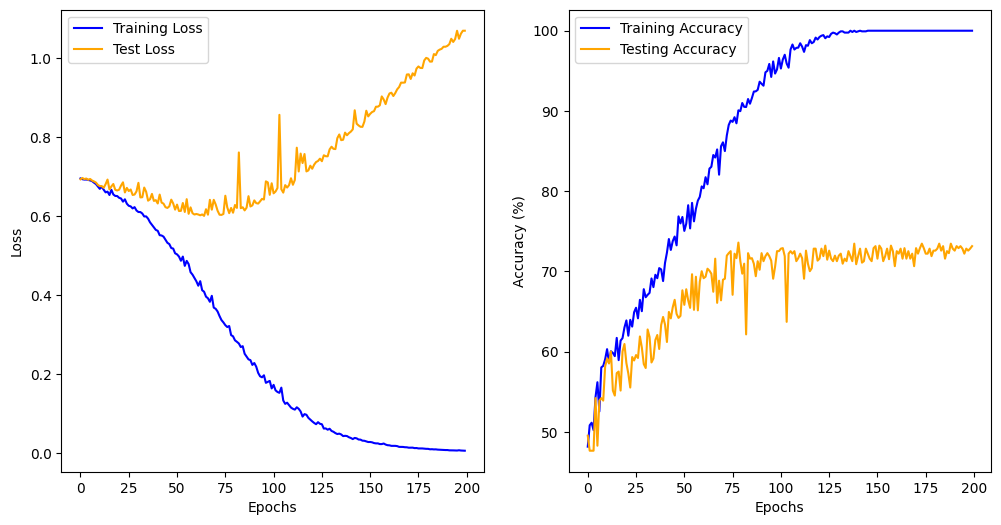

In [26]:
epochs = range(EPOCHS)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(epochs, train_losses, color = 'blue', label = "Training Loss")
ax1.plot(epochs, test_losses, color = 'orange', label = "Test Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs, train_accs, color = 'blue', label = "Training Accuracy")
ax2.plot(epochs, test_accs, color = 'orange', label = "Testing Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()